In [0]:
%tensorflow_version 1.x
#mengimport library
import numpy as np
import pickle
import cv2
from os import listdir
import warnings
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D,Convolution2D,AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers.merge import concatenate
from keras.models import Model
from keras import regularizers
from keras import initializers
from keras import backend as K
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
#Memasukkan dataset
!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip

Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:00, 168MB/s]
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all/

In [0]:
# Hyperparameter
import numpy as np
import tensorflow as tf
DATASET_PATH = '/content/two/train'
test_dir = '/content/two/test'
IMAGE_SIZE = (299, 299)
NUM_CLASSES = len("79")
BATCH_SIZE = 10 # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS =100
LEARNING_RATE =0.0005 

In [0]:
#Train datagen adalah sebuah preprocessor disini
train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=50, featurewise_center = True, featurewise_std_normalization = True,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.25, zoom_range=0.1,
 zca_whitening = True, channel_shift_range = 20, horizontal_flip = True ,
 vertical_flip = True , validation_split = 0.2, fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
 target_size=IMAGE_SIZE, shuffle=True, batch_size=BATCH_SIZE,
 subset = "training", seed=42, class_mode="binary",
 )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
 target_size=IMAGE_SIZE, shuffle=True, batch_size=BATCH_SIZE,
 subset = "validation", seed=42, class_mode="binary",
 )

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [0]:
'''
Copyright 2017 TensorFlow Authors and Kent Sommer

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''



#########################################################################################
# Mengimplementasikan Inception v4 #
#########################################################################################

WEIGHTS_PATH = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'


def preprocess_input(x):
    x = np.divide(x, 255.0)
    x = np.subtract(x, 0.5)
    x = np.multiply(x, 2.0)
    return x

def conv2d_bn(x, nb_filter, num_row, num_col,
              padding='same', strides=(1, 1), use_bias=False):
    """
    Utility function to apply conv + BN. 
    (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
    """
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    x = Convolution2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x

def block_inception_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 96, 1, 1)
    branch_1 = conv2d_bn(input, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3)
    branch_2 = conv2d_bn(input, 64, 1, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1, 1)
    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x

def block_reduction_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')
    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')
    branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)
    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x
def block_inception_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    branch_0 = conv2d_bn(input, 384, 1, 1)
    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1, 7)
    branch_1 = conv2d_bn(branch_1, 256, 7, 1)
    branch_2 = conv2d_bn(input, 192, 1, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7, 1)
    branch_2 = conv2d_bn(branch_2, 224, 1, 7)
    branch_2 = conv2d_bn(branch_2, 224, 7, 1)
    branch_2 = conv2d_bn(branch_2, 256, 1, 7)
    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1, 1)
    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x

def block_reduction_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    branch_0 = conv2d_bn(input, 192, 1, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')
    branch_1 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1, 7)
    branch_1 = conv2d_bn(branch_1, 320, 7, 1)
    branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')
    branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)
    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x
def block_inception_c(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    branch_0 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(input, 384, 1, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1, 3)
    branch_11 = conv2d_bn(branch_1, 256, 3, 1)
    branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)
    branch_2 = conv2d_bn(input, 384, 1, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3, 1)
    branch_2 = conv2d_bn(branch_2, 512, 1, 3)
    branch_20 = conv2d_bn(branch_2, 256, 1, 3)
    branch_21 = conv2d_bn(branch_2, 256, 3, 1)
    branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)
    branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1, 1)
    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x
def inception_v4_base(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    #Stem Block
    net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
    net = conv2d_bn(net, 32, 3, 3, padding='valid')
    net = conv2d_bn(net, 64, 3, 3)
    branch_0 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
    branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')
    net = concatenate([branch_0, branch_1], axis=channel_axis)
    branch_0 = conv2d_bn(net, 64, 1, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')
    branch_1 = conv2d_bn(net, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1, 7)
    branch_1 = conv2d_bn(branch_1, 64, 7, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')
    net = concatenate([branch_0, branch_1], axis=channel_axis)
    branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
    branch_1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
    net = concatenate([branch_0, branch_1], axis=channel_axis)
    # 35 x 35 x 384
    # 4 x Inception-A blocks
    for idx in range(4):
    	net = block_inception_a(net)
    # 35 x 35 x 384
    # Reduction-A block
    net = block_reduction_a(net)
    # 17 x 17 x 1024
    # 7 x Inception-B blocks
    for idx in range(7):
    	net = block_inception_b(net)
    # 17 x 17 x 1024
    # Reduction-B block
    net = block_reduction_b(net)
    # 8 x 8 x 1536
    # 3 x Inception-C blocks
    for idx in range(3):
    	net = block_inception_c(net)
    return net
def inception_v4(num_classes, dropout_keep_prob, weights, include_top):
    '''
    Creates the inception v4 network

    Args:
    	num_classes: number of classes
    	dropout_keep_prob: float, the fraction to keep before final layer.
    
    Returns: 
    	logits: the logits outputs of the model.
    '''
    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
    if K.image_data_format() == 'channels_first':
        inputs = Input((3, 299, 299))
    else:
        inputs = Input((299, 299, 3))
    # Make inception base
    x = inception_v4_base(inputs)
    # Final pooling and prediction
    if include_top:
        # 1 x 1 x 1536
        x = AveragePooling2D((8,8), padding='valid')(x)
        x = Dropout(dropout_keep_prob)(x)
        x = Flatten()(x)
        # 1536
        x = Dense(units=num_classes, activation='softmax')(x)
    model = Model(inputs, x, name='inception_v4')
    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
        if include_top:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='9fe79d77f793fe874470d84ca6ba4a3b')
        else:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='9296b46b5971573064d12e4669110969')
        model.load_weights(weights_path, by_name=True)
    return model


def create_model(num_classes=1001, dropout_prob=0.2, weights=None, include_top=False):
    return inception_v4(num_classes, dropout_prob, weights, include_top)
# ----------------------------------------------------------
incept_model = create_model(num_classes=1001, dropout_prob=0.2, weights=None, include_top=False)
incept_model.load_weights('/content/drive/My Drive/Deep Learning/input/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5')
for l in incept_model.layers: 
    if l is not None: l.trainable = True 
        
x = incept_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = BatchNormalization()(x)
#x = Dense(1024, activation='relu')(x)
#x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
#x = Dropout(0.2)(x)
predictions = Dense(1, activation='softmax')(x)

model = Model(inputs=incept_model.input, outputs=predictions)        


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
#Proses compile
from keras import optimizers
model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=LEARNING_RATE),metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#Menampilkan epoch
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
result=model.fit_generator(train_batches,
 steps_per_epoch =10,
 validation_data = valid_batches,
 validation_steps = STEP_SIZE_VALID,
 epochs= NUM_EPOCHS,
 )



Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/10 [==============================] - 49s 5s/step - loss: 8.1874 - acc: 0.5300 - val_loss: 7.7990 - val_acc: 0.5500
Epoch 2/100
10/10 [==============================] - 8s 800ms/step - loss: 7.5142 - acc: 0.5643 - val_loss: 9.4684 - val_acc: 0.4375
Epoch 3/100
10/10 [==============================] - 5s 512ms/step - loss: 7.7248 - acc: 0.5438 - val_loss: 6.3753 - val_acc: 0.6250
Epoch 4/100
10/10 [==============================] - 6s 604ms/step - loss: 8.1704 - acc: 0.5100 - val_loss: 6.6928 - val_acc: 0.6000
Epoch 5/100
10/10 [==============================] - 6s 579ms/step - loss: 7.1281 - acc: 0.5709 - val_loss: 7.2292 - val_acc: 0.5625
Epoch 6/100
10/10 [==============================] - 5s 530ms/step - loss: 7.4066 - acc: 0.5500 - val_loss: 9.1757 - val_acc: 0.4375
Epoch 7/100
10/10 [==============================] - 6s 579ms/step - loss: 7.5212 - acc: 0.5402 - val_loss: 8.9412 - val_acc: 0.4500
Epoch 8/100
10/10 [==============================] - 6s 617ms/step - loss: 7.8106 -

In [0]:
#Menampilkan akurasi
score=model.evaluate(valid_batches, verbose=True)
print("Test Accuracy : %0.02f %%" % (score [1]*100))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


3/3 [==============================] - 1s 343ms/step
Test Accuracy : 53.85 %


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


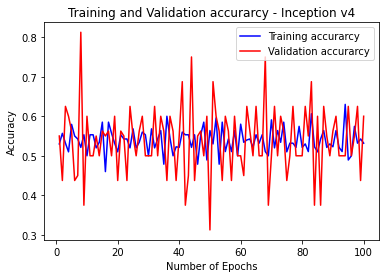

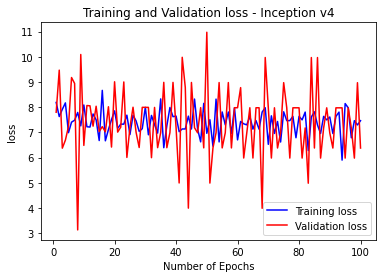

In [0]:
#Visualisasi akurasi dan loss

acc = result.history['acc']
val_acc = result.history['val_acc']
loss = result.history['loss']
val_loss = result.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy - Inception v4')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss - Inception v4')
plt.ylabel('loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.show()